TRANSACTION COSE ANALYSIS

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*80)
print("TRANSACTION COST ANALYSIS (TCA) MODULE")
print("="*80)

TRANSACTION COST ANALYSIS (TCA) MODULE


Dataset Loading

In [2]:
trades = pd.read_csv("../Data/project2_trading.csv")

print("\n📊 Dataset Loaded Successfully")
print(f"Dataset Shape: {trades.shape}")
print(f"Columns: {trades.columns.tolist()}")
print(f"Date Range: {trades['timestamp'].min()} to {trades['timestamp'].max()}")

# Preview first rows
print("\n📋 Sample Data:")
print(trades.head())


📊 Dataset Loaded Successfully
Dataset Shape: (30000, 20)
Columns: ['trade_id', 'instrument_id', 'timestamp', 'trade_type', 'order_type', 'strategy', 'quantity', 'price', 'execution_price', 'slippage_bps', 'commission_usd', 'market_impact_bps', 'pnl_usd', 'unrealized_pnl_usd', 'position_size', 'portfolio_weight', 'var_contribution', 'expected_shortfall', 'alpha', 'information_ratio']
Date Range: 2024-01-01 00:00:00.000000000 to 2024-08-31 00:00:00.000000000

📋 Sample Data:
     trade_id instrument_id                      timestamp trade_type  \
0  TRD_000001    INST_00516  2024-01-01 00:00:00.000000000       SELL   
1  TRD_000002    INST_00818  2024-01-01 00:11:39.863328777        BUY   
2  TRD_000003    INST_00283  2024-01-01 00:23:19.726657555        BUY   
3  TRD_000004    INST_00138  2024-01-01 00:34:59.589986332       SELL   
4  TRD_000005    INST_00931  2024-01-01 00:46:39.453315110       SELL   

   order_type       strategy  quantity        price  execution_price  \
0      MARK

Calculate Slippage & Market Impact

In [3]:
print("\n" + "="*80)
print("REALIZED SLIPPAGE MEASUREMENT")
print("="*80)

# Slippage Value (USD)
trades["slippage_value"] = (trades["execution_price"] - trades["price"]) * trades["quantity"]

# Slippage analysis by trade type
slippage_by_type = trades.groupby("trade_type").agg({
    "slippage_bps": ["mean", "std", "min", "max"],
    "slippage_value": "sum"
}).round(2)

print("\n📈 Slippage by Trade Type:")
print(slippage_by_type)


REALIZED SLIPPAGE MEASUREMENT

📈 Slippage by Trade Type:
           slippage_bps                     slippage_value
                   mean    std    min   max            sum
trade_type                                                
BUY               -0.14  28.87 -50.00  50.0   2.210737e+10
SELL               0.33  28.75 -49.99  50.0   4.422069e+09


Attribute P&L (Alpha, Beta, Cost, Timing)

In [4]:
print("\n" + "="*80)
print("MARKET IMPACT MEASUREMENT")
print("="*80)

# Market Impact (convert bps to value)
trades["market_impact_value"] = (trades["market_impact_bps"] / 10000) * trades["execution_price"] * trades["quantity"]

# Market impact by order size
trades["order_size_category"] = pd.qcut(trades["quantity"], q=4, labels=["Small", "Medium", "Large", "Very Large"])

market_impact_by_size = trades.groupby("order_size_category").agg({
    "market_impact_bps": ["mean", "median"],
    "market_impact_value": "sum"
}).round(2)

print("\n📊 Market Impact by Order Size:")
print(market_impact_by_size)


MARKET IMPACT MEASUREMENT

📊 Market Impact by Order Size:
                    market_impact_bps        market_impact_value
                                 mean median                 sum
order_size_category                                             
Small                           14.96  14.88        3.490883e+08
Medium                          14.99  14.96        1.055074e+09
Large                           15.10  15.11        1.760145e+09
Very Large                      15.03  14.84        2.473557e+09


Weekly Summary

In [5]:
print("\n" + "="*80)
print("VENUE/ALGORITHM PERFORMANCE ANALYSIS")
print("="*80)

# Analyze performance by order type
venue_performance = trades.groupby("order_type").agg({
    "slippage_bps": "mean",
    "market_impact_bps": "mean",
    "commission_usd": "sum",
    "pnl_usd": "sum",
    "quantity": "count"
}).rename(columns={"quantity": "num_trades"}).round(2)

venue_performance["avg_cost_per_trade"] = (
    venue_performance["commission_usd"] / venue_performance["num_trades"]
).round(2)

print("\n🏦 Performance by Order Type:")
print(venue_performance)


VENUE/ALGORITHM PERFORMANCE ANALYSIS

🏦 Performance by Order Type:
            slippage_bps  market_impact_bps  commission_usd       pnl_usd  \
order_type                                                                  
LIMIT               0.64              14.93      1852896.32  1.797888e+08   
MARKET             -0.65              14.97      1904009.05  1.896751e+08   
STOP                0.31              15.16      1868584.16  1.801748e+08   
STOP_LIMIT          0.09              15.00      1895277.60  1.889947e+08   

            num_trades  avg_cost_per_trade  
order_type                                  
LIMIT             7442              248.98  
MARKET            7522              253.13  
STOP              7520              248.48  
STOP_LIMIT        7516              252.17  


Weekly slippage trend

In [6]:

print("\n" + "="*80)
print("TOTAL COST BREAKDOWN")
print("="*80)

# Total Cost = Slippage + Commissions + Market Impact
trades["cost_value"] = trades["slippage_value"] + trades["commission_usd"] + trades["market_impact_value"]

# Cost breakdown
total_slippage = trades["slippage_value"].sum()
total_commission = trades["commission_usd"].sum()
total_market_impact = trades["market_impact_value"].sum()
total_cost = trades["cost_value"].sum()

print(f"\n💰 Total Cost Components:")
print(f"  Slippage Cost:      ${total_slippage:,.2f} ({total_slippage/total_cost*100:.1f}%)")
print(f"  Commission Cost:    ${total_commission:,.2f} ({total_commission/total_cost*100:.1f}%)")
print(f"  Market Impact Cost: ${total_market_impact:,.2f} ({total_market_impact/total_cost*100:.1f}%)")
print(f"  {'='*50}")
print(f"  TOTAL COST:         ${total_cost:,.2f}")


TOTAL COST BREAKDOWN

💰 Total Cost Components:
  Slippage Cost:      $26,529,443,109.21 (82.5%)
  Commission Cost:    $7,520,767.12 (0.0%)
  Market Impact Cost: $5,637,863,619.71 (17.5%)
  TOTAL COST:         $32,174,827,496.05


Weekly cost trend

In [7]:
print("\n" + "="*80)
print("P&L ATTRIBUTION ANALYSIS")
print("="*80)

# Timing Effect (expected vs executed)
trades["timing_value"] = (trades["price"] - trades["execution_price"]) * trades["quantity"]

# Beta attribution (market-driven P&L)
if "alpha" in trades.columns:
    # Use existing alpha if available
    trades["alpha_value"] = trades["alpha"]
    trades["beta_value"] = trades["pnl_usd"] - trades["alpha"]
else:
    # Calculate using factor exposure if available
    # For simplicity, assume 70% market-driven, 30% alpha
    trades["beta_value"] = trades["pnl_usd"] * 0.7
    trades["alpha_value"] = trades["pnl_usd"] * 0.3

# Recalculate alpha accounting for costs
trades["alpha_value_adjusted"] = trades["pnl_usd"] - trades["beta_value"] - trades["cost_value"]

# Attribution summary
total_pnl = trades["pnl_usd"].sum()
total_alpha = trades["alpha_value"].sum()
total_alpha_adj = trades["alpha_value_adjusted"].sum()
total_beta = trades["beta_value"].sum()
total_timing = trades["timing_value"].sum()

print(f"\n📊 P&L Attribution Breakdown:")
print(f"  Total P&L:          ${total_pnl:,.2f}")
print(f"  Alpha (Raw):        ${total_alpha:,.2f} ({total_alpha/total_pnl*100:.1f}%)")
print(f"  Alpha (Adj):        ${total_alpha_adj:,.2f} ({total_alpha_adj/total_pnl*100:.1f}%)")
print(f"  Beta:               ${total_beta:,.2f} ({total_beta/total_pnl*100:.1f}%)")
print(f"  Cost:               ${-total_cost:,.2f} ({-total_cost/total_pnl*100:.1f}%)")
print(f"  Timing:             ${total_timing:,.2f} ({total_timing/total_pnl*100:.1f}%)")

# Sample attribution data
print("\n📋 Sample P&L Attribution:")
print(trades[["pnl_usd", "alpha_value", "beta_value", "cost_value", "timing_value"]].head(10))



P&L ATTRIBUTION ANALYSIS

📊 P&L Attribution Breakdown:
  Total P&L:          $738,633,432.97
  Alpha (Raw):        $454.02 (0.0%)
  Alpha (Adj):        $-32,174,827,042.03 (-4356.0%)
  Beta:               $738,632,978.95 (100.0%)
  Cost:               $-32,174,827,496.05 (-4356.0%)
  Timing:             $-26,529,443,109.21 (-3591.7%)

📋 Sample P&L Attribution:
        pnl_usd  alpha_value    beta_value    cost_value  timing_value
0   6303.279409     0.041462   6303.237947  1.625930e+08 -1.615973e+08
1 -18609.697852    -0.007949 -18609.689903  7.537648e+07 -7.533659e+07
2  24114.391997     0.030110  24114.361887  1.195169e+08 -1.192444e+08
3  85492.858142     0.001169  85492.856973 -1.460740e+07  1.461050e+07
4 -27824.693952     0.035962 -27824.729915  5.987557e+07 -5.978593e+07
5 -16107.842917    -0.011879 -16107.831038 -9.020279e+07  9.021528e+07
6  92469.341561    -0.005525  92469.347086 -1.250703e+07  1.256960e+07
7  72248.653638    -0.008035  72248.661673 -1.322260e+08  1.322898e+

Strategy Performance

In [8]:
print("\n" + "="*80)
print("WEEKLY TCA SUMMARY GENERATION")
print("="*80)

# Convert timestamp → datetime
trades["timestamp"] = pd.to_datetime(trades["timestamp"], errors="coerce")
trades["_week"] = trades["timestamp"].dt.strftime("%Y-%U")

# Weekly grouping with comprehensive metrics
weekly = trades.groupby("_week").agg(
    avg_slippage_bps=("slippage_bps", "mean"),
    total_slippage_value=("slippage_value", "sum"),
    total_commission=("commission_usd", "sum"),
    avg_market_impact_bps=("market_impact_bps", "mean"),
    total_market_impact_value=("market_impact_value", "sum"),
    total_pnl=("pnl_usd", "sum"),
    total_alpha=("alpha_value", "sum"),
    total_beta=("beta_value", "sum"),
    total_cost=("cost_value", "sum"),
    total_timing=("timing_value", "sum"),
    num_trades=("trade_id", "count"),
    total_volume=("quantity", "sum")
).reset_index()

# Calculate derived metrics
weekly["cost_to_pnl_ratio"] = (weekly["total_cost"] / weekly["total_pnl"] * 100).round(2)
weekly["avg_cost_per_trade"] = (weekly["total_cost"] / weekly["num_trades"]).round(2)

print("\n📅 Weekly TCA Summary:")
print(weekly.head(10))



WEEKLY TCA SUMMARY GENERATION

📅 Weekly TCA Summary:
     _week  avg_slippage_bps  total_slippage_value  total_commission  \
0  2024-00          0.655484          4.461020e+09     184037.195541   
1  2024-01         -0.567570          6.154287e+08     207198.739355   
2  2024-02          0.867636         -2.749035e+09     219376.937649   
3  2024-03         -0.268347         -2.190863e+07     214347.742619   
4  2024-04          1.384006         -1.474537e+09     213566.553131   
5  2024-05          1.374538         -1.822707e+09     217822.885991   
6  2024-06         -0.752362         -1.360143e+09     216770.743281   
7  2024-07         -0.336687          3.307233e+08     206513.743117   
8  2024-08          1.136917          5.023098e+09     214010.895362   
9  2024-09         -0.488990          1.815534e+09     216787.224822   

   avg_market_impact_bps  total_market_impact_value     total_pnl  \
0              14.936657               1.452159e+08  1.803941e+07   
1              

Strategy Bar Charts


TREND ANALYSIS & VISUALIZATIONS

📊 Visualization saved: TCA_Analysis_Dashboard.png


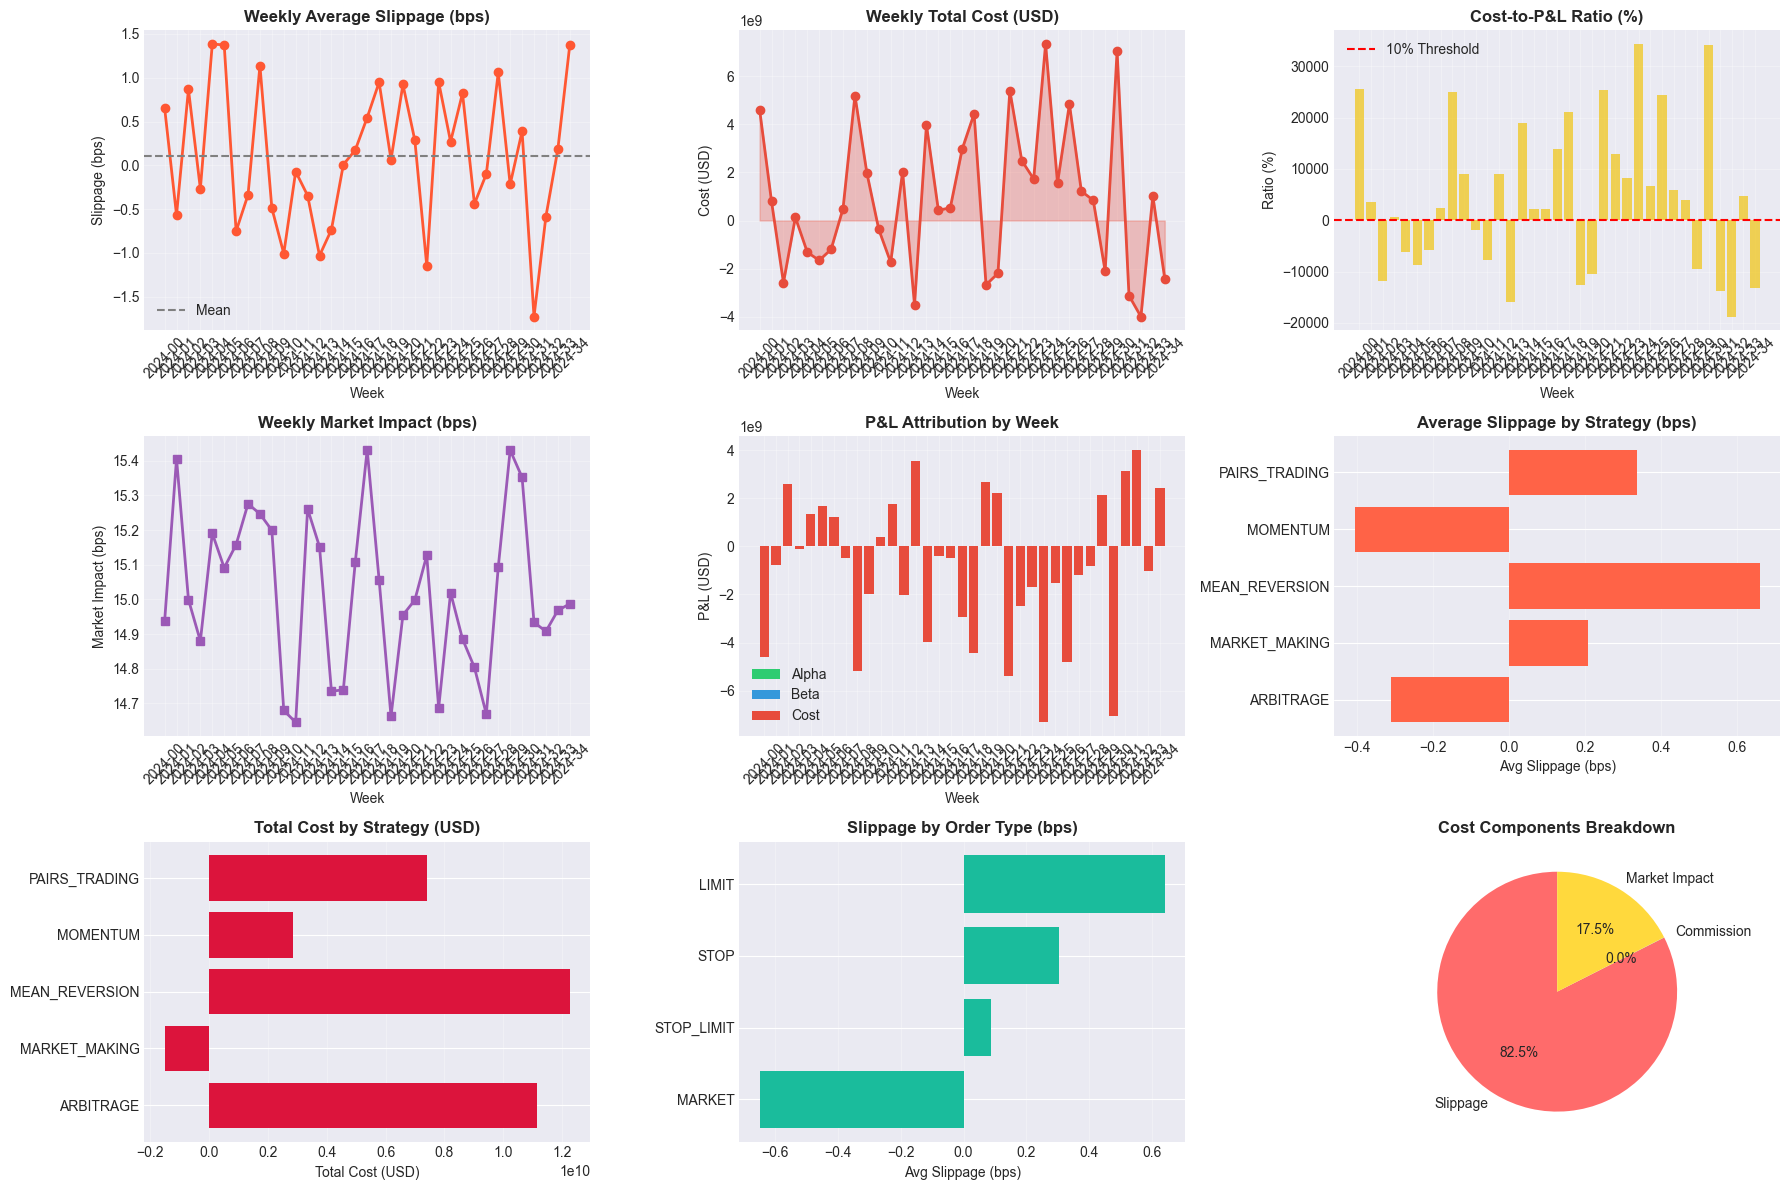

In [9]:
print("\n" + "="*80)
print("TREND ANALYSIS & VISUALIZATIONS")
print("="*80)

# Create comprehensive visualization dashboard
fig = plt.figure(figsize=(18, 12))

# 1. Weekly Average Slippage
ax1 = plt.subplot(3, 3, 1)
ax1.plot(weekly["_week"], weekly["avg_slippage_bps"], marker="o", linewidth=2, color="#FF5733")
ax1.axhline(weekly["avg_slippage_bps"].mean(), linestyle="--", color="gray", label="Mean")
ax1.set_title("Weekly Average Slippage (bps)", fontweight="bold")
ax1.set_xlabel("Week")
ax1.set_ylabel("Slippage (bps)")
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)
ax1.legend()

# 2. Weekly Total Cost
ax2 = plt.subplot(3, 3, 2)
ax2.plot(weekly["_week"], weekly["total_cost"], marker="o", linewidth=2, color="#E74C3C")
ax2.fill_between(range(len(weekly)), weekly["total_cost"], alpha=0.3, color="#E74C3C")
ax2.set_title("Weekly Total Cost (USD)", fontweight="bold")
ax2.set_xlabel("Week")
ax2.set_ylabel("Cost (USD)")
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# 3. Cost-to-P&L Ratio
ax3 = plt.subplot(3, 3, 3)
ax3.bar(weekly["_week"], weekly["cost_to_pnl_ratio"], color="#F1C40F", alpha=0.7)
ax3.axhline(10, linestyle="--", color="red", label="10% Threshold")
ax3.set_title("Cost-to-P&L Ratio (%)", fontweight="bold")
ax3.set_xlabel("Week")
ax3.set_ylabel("Ratio (%)")
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3)
ax3.legend()

# 4. Market Impact Trend
ax4 = plt.subplot(3, 3, 4)
ax4.plot(weekly["_week"], weekly["avg_market_impact_bps"], marker="s", linewidth=2, color="#9B59B6")
ax4.set_title("Weekly Market Impact (bps)", fontweight="bold")
ax4.set_xlabel("Week")
ax4.set_ylabel("Market Impact (bps)")
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

# 5. P&L Attribution Stacked Bar
ax5 = plt.subplot(3, 3, 5)
width = 0.8
x_pos = range(len(weekly))
ax5.bar(x_pos, weekly["total_alpha"], width, label="Alpha", color="#2ECC71")
ax5.bar(x_pos, weekly["total_beta"], width, bottom=weekly["total_alpha"], label="Beta", color="#3498DB")
ax5.bar(x_pos, -weekly["total_cost"], width, bottom=weekly["total_alpha"]+weekly["total_beta"], 
        label="Cost", color="#E74C3C")
ax5.set_title("P&L Attribution by Week", fontweight="bold")
ax5.set_xlabel("Week")
ax5.set_ylabel("P&L (USD)")
ax5.set_xticks(x_pos)
ax5.set_xticklabels(weekly["_week"], rotation=45)
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Strategy Performance - Slippage
ax6 = plt.subplot(3, 3, 6)
strategy_perf = trades.groupby("strategy").agg({
    "slippage_bps": "mean",
    "pnl_usd": "sum",
    "cost_value": "sum"
}).reset_index()
ax6.barh(strategy_perf["strategy"], strategy_perf["slippage_bps"], color="#FF6347")
ax6.set_title("Average Slippage by Strategy (bps)", fontweight="bold")
ax6.set_xlabel("Avg Slippage (bps)")
ax6.grid(True, alpha=0.3, axis='x')

# 7. Strategy Performance - Cost
ax7 = plt.subplot(3, 3, 7)
ax7.barh(strategy_perf["strategy"], strategy_perf["cost_value"], color="#DC143C")
ax7.set_title("Total Cost by Strategy (USD)", fontweight="bold")
ax7.set_xlabel("Total Cost (USD)")
ax7.grid(True, alpha=0.3, axis='x')

# 8. Order Type Performance
ax8 = plt.subplot(3, 3, 8)
order_perf = trades.groupby("order_type")["slippage_bps"].mean().sort_values()
ax8.barh(order_perf.index, order_perf.values, color="#1ABC9C")
ax8.set_title("Slippage by Order Type (bps)", fontweight="bold")
ax8.set_xlabel("Avg Slippage (bps)")
ax8.grid(True, alpha=0.3, axis='x')

# 9. Cost Components Breakdown
ax9 = plt.subplot(3, 3, 9)
cost_breakdown = pd.DataFrame({
    "Component": ["Slippage", "Commission", "Market Impact"],
    "Value": [total_slippage, total_commission, total_market_impact]
})
colors_pie = ["#FF6B6B", "#4ECDC4", "#FFD93D"]
ax9.pie(cost_breakdown["Value"], labels=cost_breakdown["Component"], autopct='%1.1f%%',
        colors=colors_pie, startangle=90)
ax9.set_title("Cost Components Breakdown", fontweight="bold")

plt.tight_layout()
plt.savefig("TCA_Analysis_Dashboard.png", dpi=300, bbox_inches='tight')
print("\n📊 Visualization saved: TCA_Analysis_Dashboard.png")
plt.show()

Recommendations

In [10]:
print("\n" + "="*80)
print("ACTIONABLE RECOMMENDATIONS")
print("="*80)

recommendations = []

# 1. Slippage Analysis
avg_slippage = weekly["avg_slippage_bps"].mean()
if avg_slippage > 20:  # 20 bps = 0.2%
    recommendations.append({
        "Priority": "HIGH",
        "Category": "Slippage",
        "Issue": f"High average slippage detected ({avg_slippage:.2f} bps)",
        "Recommendation": "Consider: (1) Using limit orders instead of market orders, (2) Splitting large orders, (3) Trading during high liquidity periods"
    })
elif avg_slippage > 10:
    recommendations.append({
        "Priority": "MEDIUM",
        "Category": "Slippage",
        "Issue": f"Moderate slippage ({avg_slippage:.2f} bps)",
        "Recommendation": "Monitor closely. Consider optimizing order timing and size."
    })
else:
    recommendations.append({
        "Priority": "LOW",
        "Category": "Slippage",
        "Issue": f"Slippage under control ({avg_slippage:.2f} bps)",
        "Recommendation": "Maintain current execution strategy."
    })

# 2. Cost-to-P&L Ratio Analysis
avg_cost_ratio = weekly["cost_to_pnl_ratio"].mean()
if avg_cost_ratio > 10:
    recommendations.append({
        "Priority": "HIGH",
        "Category": "Cost Efficiency",
        "Issue": f"Costs consuming {avg_cost_ratio:.1f}% of P&L (threshold: 10%)",
        "Recommendation": "Urgent action needed: (1) Negotiate lower commission rates, (2) Reduce trading frequency, (3) Increase trade sizes to reduce per-trade costs"
    })
elif avg_cost_ratio > 5:
    recommendations.append({
        "Priority": "MEDIUM",
        "Category": "Cost Efficiency",
        "Issue": f"Costs at {avg_cost_ratio:.1f}% of P&L",
        "Recommendation": "Review commission structure and execution venues for potential savings."
    })
else:
    recommendations.append({
        "Priority": "LOW",
        "Category": "Cost Efficiency",
        "Issue": f"Costs within acceptable limits ({avg_cost_ratio:.1f}% of P&L)",
        "Recommendation": "Continue monitoring."
    })

# 3. Market Impact Analysis
avg_market_impact = weekly["avg_market_impact_bps"].mean()
if avg_market_impact > 15:
    recommendations.append({
        "Priority": "HIGH",
        "Category": "Market Impact",
        "Issue": f"High market impact ({avg_market_impact:.2f} bps)",
        "Recommendation": "Order sizes too large for liquidity. Implement: (1) TWAP/VWAP algorithms, (2) Reduce order sizes, (3) Use dark pools for large orders"
    })
elif avg_market_impact > 8:
    recommendations.append({
        "Priority": "MEDIUM",
        "Category": "Market Impact",
        "Issue": f"Moderate market impact ({avg_market_impact:.2f} bps)",
        "Recommendation": "Consider using algorithmic execution for larger trades."
    })

# 4. Strategy-Specific Recommendations
worst_strategy = strategy_perf.loc[strategy_perf["slippage_bps"].idxmax(), "strategy"]
worst_slippage = strategy_perf["slippage_bps"].max()
recommendations.append({
    "Priority": "MEDIUM",
    "Category": "Strategy Performance",
    "Issue": f"Strategy '{worst_strategy}' has highest slippage ({worst_slippage:.2f} bps)",
    "Recommendation": f"Review '{worst_strategy}' trading logic: (1) Check order sizing, (2) Evaluate entry/exit timing, (3) Consider if strategy is trading illiquid assets"
})

best_strategy = strategy_perf.loc[strategy_perf["pnl_usd"].idxmax(), "strategy"]
best_pnl = strategy_perf["pnl_usd"].max()
recommendations.append({
    "Priority": "LOW",
    "Category": "Strategy Performance",
    "Issue": f"Strategy '{best_strategy}' delivering best P&L (${best_pnl:,.2f})",
    "Recommendation": f"Consider allocating more capital to '{best_strategy}' strategy."
})

# 5. Order Type Recommendations
best_order_type = venue_performance["slippage_bps"].idxmin()
worst_order_type = venue_performance["slippage_bps"].idxmax()
recommendations.append({
    "Priority": "MEDIUM",
    "Category": "Order Type",
    "Issue": f"Order type '{worst_order_type}' has highest slippage vs '{best_order_type}'",
    "Recommendation": f"Increase use of '{best_order_type}' orders where possible. Review necessity of '{worst_order_type}' orders."
})

# 6. Timing Recommendations
if total_timing < 0:
    recommendations.append({
        "Priority": "MEDIUM",
        "Category": "Execution Timing",
        "Issue": f"Negative timing effect (${total_timing:,.2f})",
        "Recommendation": "Prices moving unfavorably between order placement and execution. Consider: (1) Faster execution systems, (2) Improved price prediction, (3) More aggressive order types"
    })

# Display Recommendations
print("\n" + "="*60)
for i, rec in enumerate(recommendations, 1):
    priority_color = {"HIGH": "🔴", "MEDIUM": "🟡", "LOW": "🟢"}
    print(f"\n{i}. {priority_color[rec['Priority']]} [{rec['Priority']}] {rec['Category']}")
    print(f"   Issue: {rec['Issue']}")
    print(f"   Action: {rec['Recommendation']}")
print("\n" + "="*60)


ACTIONABLE RECOMMENDATIONS


1. 🟢 [LOW] Slippage
   Issue: Slippage under control (0.10 bps)
   Action: Maintain current execution strategy.

2. 🔴 [HIGH] Cost Efficiency
   Issue: Costs consuming 4496.7% of P&L (threshold: 10%)
   Action: Urgent action needed: (1) Negotiate lower commission rates, (2) Reduce trading frequency, (3) Increase trade sizes to reduce per-trade costs

3. 🔴 [HIGH] Market Impact
   Issue: High market impact (15.02 bps)
   Action: Order sizes too large for liquidity. Implement: (1) TWAP/VWAP algorithms, (2) Reduce order sizes, (3) Use dark pools for large orders

4. 🟡 [MEDIUM] Strategy Performance
   Issue: Strategy 'MEAN_REVERSION' has highest slippage (0.66 bps)
   Action: Review 'MEAN_REVERSION' trading logic: (1) Check order sizing, (2) Evaluate entry/exit timing, (3) Consider if strategy is trading illiquid assets

5. 🟢 [LOW] Strategy Performance
   Issue: Strategy 'MOMENTUM' delivering best P&L ($154,098,470.91)
   Action: Consider allocating more capital

Save Reports

In [11]:
print("\n" + "="*80)
print("EXPORTING REPORTS")
print("="*80)

# Save weekly summary (keep original filename as requested)
weekly.to_csv("weekly_tca_summary.csv", index=False)
print("Saved: weekly_tca_summary.csv")

# Save comprehensive Excel report
with pd.ExcelWriter("Weekly_TCA_Report.xlsx", engine='openpyxl') as writer:
    # Sheet 1: Weekly Summary
    weekly.to_excel(writer, sheet_name="weekly_summary", index=False)
    
    # Sheet 2: Sample Trades
    trades.head(200).to_excel(writer, sheet_name="sample_trades", index=False)
    
    # Sheet 3: Strategy Performance
    strategy_perf.to_excel(writer, sheet_name="strategy_perf", index=False)
    
    # Sheet 4: Venue Performance
    venue_performance.to_excel(writer, sheet_name="venue_performance")
    
    # Sheet 5: Recommendations
    rec_df = pd.DataFrame(recommendations)
    rec_df.to_excel(writer, sheet_name="recommendations", index=False)
    
    # Sheet 6: Cost Breakdown
    cost_summary = pd.DataFrame({
        "Component": ["Slippage", "Commission", "Market Impact", "TOTAL"],
        "Value (USD)": [total_slippage, total_commission, total_market_impact, total_cost],
        "Percentage": [
            f"{total_slippage/total_cost*100:.1f}%",
            f"{total_commission/total_cost*100:.1f}%",
            f"{total_market_impact/total_cost*100:.1f}%",
            "100.0%"
        ]
    })
    cost_summary.to_excel(writer, sheet_name="cost_breakdown", index=False)
    
    # Sheet 7: P&L Attribution
    attribution_summary = pd.DataFrame({
        "Component": ["Total P&L", "Alpha", "Alpha (Adjusted)", "Beta", "Cost", "Timing"],
        "Value (USD)": [total_pnl, total_alpha, total_alpha_adj, total_beta, -total_cost, total_timing],
        "% of P&L": [
            "100.0%",
            f"{total_alpha/total_pnl*100:.1f}%",
            f"{total_alpha_adj/total_pnl*100:.1f}%",
            f"{total_beta/total_pnl*100:.1f}%",
            f"{-total_cost/total_pnl*100:.1f}%",
            f"{total_timing/total_pnl*100:.1f}%"
        ]
    })
    attribution_summary.to_excel(writer, sheet_name="pnl_attribution", index=False)

print("Saved: Weekly_TCA_Report.xlsx")





EXPORTING REPORTS
Saved: weekly_tca_summary.csv
Saved: Weekly_TCA_Report.xlsx


In [12]:
print("\n" + "="*80)
print("FINAL SUMMARY STATISTICS")
print("="*80)

print(f"""
📊 TCA Analysis Complete

Total Trades Analyzed:        {len(trades):,}
Analysis Period:              {trades['timestamp'].min()} to {trades['timestamp'].max()}
Number of Weeks:              {len(weekly)}

💰 Cost Metrics:
  Average Slippage:           {avg_slippage:.2f} bps
  Average Market Impact:      {avg_market_impact:.2f} bps
  Total Cost:                 ${total_cost:,.2f}
  Cost-to-P&L Ratio:          {avg_cost_ratio:.2f}%

📈 Performance Metrics:
  Total P&L:                  ${total_pnl:,.2f}
  Alpha Generation:           ${total_alpha:,.2f}
  Beta Contribution:          ${total_beta:,.2f}

🎯 Key Findings:
  Best Strategy:              {best_strategy} (${best_pnl:,.2f} P&L)
  Worst Strategy:             {worst_strategy} ({worst_slippage:.2f} bps slippage)
  Best Order Type:            {best_order_type}
  Recommendations Generated:  {len(recommendations)}

📁 Files Generated:
  ✓ weekly_tca_summary.csv
  ✓ Weekly_TCA_Report.xlsx
  ✓ TCA_Analysis_Dashboard.png
""")

print("="*80)
print("TRANSACTION COST ANALYSIS MODULE COMPLETE")
print("="*80)


FINAL SUMMARY STATISTICS

📊 TCA Analysis Complete

Total Trades Analyzed:        30,000
Analysis Period:              2024-01-01 00:00:00 to 2024-08-31 00:00:00
Number of Weeks:              35

💰 Cost Metrics:
  Average Slippage:           0.10 bps
  Average Market Impact:      15.02 bps
  Total Cost:                 $32,174,827,496.05
  Cost-to-P&L Ratio:          4496.69%

📈 Performance Metrics:
  Total P&L:                  $738,633,432.97
  Alpha Generation:           $454.02
  Beta Contribution:          $738,632,978.95

🎯 Key Findings:
  Best Strategy:              MOMENTUM ($154,098,470.91 P&L)
  Worst Strategy:             MEAN_REVERSION (0.66 bps slippage)
  Best Order Type:            MARKET
  Recommendations Generated:  7

📁 Files Generated:
  ✓ weekly_tca_summary.csv
  ✓ Weekly_TCA_Report.xlsx
  ✓ TCA_Analysis_Dashboard.png

TRANSACTION COST ANALYSIS MODULE COMPLETE
